# DiffEdit Variation
这本笔记本展示了论文["DIFFEDIT: 基于震荡的半透明图像编辑与遮罩引导"](https://arxiv.org/abs/2210.11427#)中所涉及的提示引导图像编辑方法的一个实验性变化。

在这篇论文中，掩码是通过获取一个参考提示和一个目标提示来生成的。 例如，参考提示：'马'，目标：'斑马'）并使用noise_pred（马）-noise_pred（斑马）生成一个噪声掩码。

在这个笔记本中，我探索了一个变体。 我注意到，当使用参考和目标的噪声预测来生成掩码时，掩码往往充满了 "洞"。 我假设这是因为参考和目标提示的噪声预测在某些情况下过于相似。 我们真正想做的是生成一个 "减去 "参考提示的掩码。 但是想出另一个能与参考提示形成强烈 "对比 "的提示是有些困难的。 因此，我想知道，如果我们不使用参考和目标提示来生成掩码，而是使用参考提示**一次带有正导向刻度，一次带有负导向**，并使用这些提示来生成掩码，会发生什么。

这似乎效果很好！... 虽然我还在探索，但结果足够好，所以我想我要分享。




In [1]:
def install_dependencies():       #dependencies：项目正常允许时需要的依赖包；
    !pip install -qq numpy
    !pip install -qq matplotlib
    !pip install -qq fastai
    !pip install -qq --upgrade transformers diffusers ftfy
    !conda install -y -qq ffmpeg


install_dependencies()

Retrieving notices: ...working... done
Solving environment: ...working... done

# All requested packages already installed.



## Imports and Setup

In [2]:
import os
import numpy as np

import matplotlib.pyplot as plt
from tqdm.auto import tqdm

from fastcore.all import concat
from pathlib import Path

from PIL import Image
import torch, logging
from torch import autocast
from torchvision import transforms as tfms

from huggingface_hub import notebook_login
from transformers import CLIPTextModel, CLIPTokenizer
from transformers import logging
from diffusers import AutoencoderKL, UNet2DConditionModel, LMSDiscreteScheduler

import cv2

# 设置设备
torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
from torch.nn.functional import threshold

In [4]:
#总结张量
_s = lambda x: (x.shape,x.max(),x.min())

##  Hugging Face认证

要在你的电脑上运行Stable Diffusion，你必须接受该模型的许可。这是一个开放的CreativeML OpenRail-M许可证，它对你产生的输出没有任何权利要求，并禁止你故意产生非法或有害的内容。[模型卡](https://huggingface.co/CompVis/stable-diffusion-v1-4)提供了更多细节。如果你接受了该许可证，你需要成为🤗Hugging Face Hub的注册用户，并使用一个访问令牌，以便代码能够工作。你有两个选择来提供你的访问令牌：

* 在你的终端使用`huggingface-cli login`命令行工具，在提示时粘贴你的令牌。它将被保存在你电脑中的一个文件中。
* 或者在笔记本中使用`notebook_login()`，它做同样的事情。

In [5]:
torch.manual_seed(1)
if not (Path.home()/'.huggingface'/'token').exists(): notebook_login()

## 负载预训练的拥抱脸模型

In [6]:
# 加载自动编码器模型，该模型将用于将潜伏物解码为图像空间。
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

#加载标记器和文本编码器，对文本进行标记和编码。
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# 用于生成潜像的UNet模型。
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# 噪声调度器
# 超参数与训练模型时使用的参数一致
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# 到GPU去吧!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModel: ['vision_model.encoder.layers.13.layer_norm2.bias', 'vision_model.encoder.layers.23.layer_norm1.bias', 'vision_model.encoder.layers.8.layer_norm2.weight', 'vision_model.encoder.layers.9.self_attn.q_proj.weight', 'vision_model.encoder.layers.14.layer_norm2.weight', 'vision_model.encoder.layers.17.self_attn.k_proj.weight', 'vision_model.encoder.layers.20.mlp.fc1.bias', 'vision_model.encoder.layers.15.layer_norm1.bias', 'vision_model.encoder.layers.13.self_attn.k_proj.weight', 'vision_model.encoder.layers.5.self_attn.q_proj.bias', 'vision_model.encoder.layers.14.self_attn.k_proj.weight', 'vision_model.encoder.layers.21.self_attn.q_proj.bias', 'vision_model.encoder.layers.17.mlp.fc1.bias', 'vision_model.encoder.layers.12.self_attn.v_proj.weight', 'vision_model.encoder.layers.6.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.self_attn.v_proj.bias', 'vision_model.e

In [7]:
vae_magic = 0.18215 # 用比例项训练的vae模型，更接近单位方差

在潜标和图像之间进行转换的函数

In [9]:
def image2latent(im):
    im = tfms.ToTensor()(im).unsqueeze(0)
    with torch.no_grad():
        latent = vae.encode(im.to(torch_device)*2-1);
    latent = latent.latent_dist.sample() * vae_magic      
    return latent

In [10]:
def decode_latent(latents):
    with torch.no_grad():
        return vae.decode(latents/vae_magic).sample

In [11]:
def latents2images(latents):
    latents = latents/vae_magic
    with torch.no_grad():
        imgs = vae.decode(latents).sample
    imgs = (imgs / 2 + 0.5).clamp(0,1)
    imgs = imgs.detach().cpu().permute(0,2,3,1).numpy()
    imgs = (imgs * 255).round().astype("uint8")
    imgs = [Image.fromarray(i) for i in imgs]
    return imgs

In [12]:
def get_embedding_for_prompt(prompt):
    max_length = tokenizer.model_max_length
    tokens = tokenizer([prompt],padding="max_length",max_length=max_length,truncation=True,return_tensors="pt")
    with torch.no_grad():
        embeddings = text_encoder(tokens.input_ids.to(torch_device))[0]
    return embeddings

In [13]:
def generate_noise_pred(prompts, im_latents, seed=32, g=0.15):
    height = 512                        # 稳定扩散的默认高度
    width = 512                         # 稳定扩散的默认宽度
    num_inference_steps = 30            # 去噪步骤的数量
    generator = torch.manual_seed(seed)   # 创建初始潜伏噪声的种子发生器

    uncond = get_embedding_for_prompt('')
    text = get_embedding_for_prompt(prompts)
    text_embeddings = torch.cat([uncond, text])

    #准备工作调度员
    scheduler.set_timesteps(num_inference_steps)

    # 预备潜伏
    if im_latents != None:
        # img2img
        #start_step = 10
        start_step = int(num_inference_steps * 0.5)
        timesteps = torch.tensor([scheduler.timesteps[-start_step]],device=torch_device)
        noise = torch.randn_like(im_latents)
        latents = scheduler.add_noise(im_latents,noise,timesteps=timesteps)
        latents = latents.to(torch_device).float()
    else:
        # 只是文本提示
        start_step = -1 # disable branching below
        latents = torch.randn((1,unet.in_channels,height//8,width//8))#,generator=generator)
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma # scale to initial amount of noise for t0

    latent_model_input = torch.cat([latents] * 2)
    latent_model_input = scheduler.scale_model_input(latent_model_input, timesteps)
    with torch.no_grad():
        u,t = unet(latent_model_input, timesteps, encoder_hidden_states=text_embeddings).sample.chunk(2)
    pred_nonscaled= u + g*(t-u)/torch.norm(t-u)*torch.norm(u)
    pred = pred_nonscaled * torch.norm(u)/torch.norm(pred_nonscaled)
    return scheduler.step(pred, timesteps, latents).pred_original_sample

In [14]:
def generate_image_from_embedding(text_embeddings, im_latents, mask=None, seed=None, guidance_scale=0.15):
    height = 512                        # 稳定扩散的默认高度
    width = 512                         # 稳定扩散的默认宽度
    num_inference_steps = 30            # 去噪步骤的数量
    if seed is None: seed = torch.seed()
    generator = torch.manual_seed(seed)   # 创建初始潜伏噪声的种子发生器

    uncond = get_embedding_for_prompt('')
    text_embeddings = torch.cat([uncond, text_embeddings])

    # Prep Scheduler
    scheduler.set_timesteps(num_inference_steps)

    # Prep latents
    
    if im_latents != None:
        # img2img
        start_step = 10
        noise = torch.randn_like(im_latents)
        latents = scheduler.add_noise(im_latents,noise,timesteps=torch.tensor([scheduler.timesteps[start_step]]))
        latents = latents.to(torch_device).float()
    else:
        # just text prompts
        start_step = -1 # disable branching below
        latents = torch.randn((1,unet.in_channels,height//8,width//8))#,generator=generator)
        latents = latents.to(torch_device)
        latents = latents * scheduler.init_noise_sigma # scale to initial amount of noise for t0

    noisy_latent = latents.clone()
    # Loop
    noise_pred = None
    for i, tm in tqdm(enumerate(scheduler.timesteps),total=num_inference_steps,desc='Generating Masked Image for Prompt'):
        if i > start_step:
            # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
            latent_model_input = torch.cat([latents] * 2)
            latent_model_input = scheduler.scale_model_input(latent_model_input, tm)

            # predict the noise residual
            with torch.no_grad():
                noise_pred = unet(latent_model_input, tm, encoder_hidden_states=text_embeddings)["sample"]

            # perform guidance
            noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
            
            u = noise_pred_uncond
            g = guidance_scale
            t = noise_pred_text

            if g > 0:
                pred_nonscaled= u + g*(t-u)/torch.norm(t-u)*torch.norm(u)
                pred = pred_nonscaled * torch.norm(u)/torch.norm(pred_nonscaled)
            else:
                pred = u

            noise_pred = pred
            
            # compute the previous noisy sample x_t -> x_t-1
            latents = scheduler.step(noise_pred, tm, latents).prev_sample
            if mask is not None: 
                latents = latents*mask+im_latents*(1.0-mask)

    noise_pred = noisy_latent-latents
    return latents2images(latents)[0],noise_pred

In [15]:
def image2latentmask(im):
    im = tfms.ToTensor()(im).permute(1,2,0)
    m = im.mean(-1) # convert to grayscale
    m = (m > 0.5).float() # binarize to 0.0 or 1.0
    m = cv2.resize(m.cpu().numpy(),(64,64),interpolation=cv2.INTER_NEAREST)
    m = torch.tensor(m).to(torch_device)
    return m

## DiffEdit掩码生成的变化
这种DiffEdit掩蔽方法的变种不是采取参考提示和目标提示，而是采取单一的提示，然后使用同一提示的正向和 "负向指导刻度 "来创建一个对比性/负向的噪声预测。

In [16]:
# 一个来自diffedit论文的变体
# 用一个提示生成一个掩码

def generate_mask_variant(encoded,prompt1):
    masks=[]
    n = 20
    for i in tqdm(range(n),desc='Generating Mask for Prompts'):
        s = torch.seed() # 对两个噪声样本使用相同的种子很重要
        n1 = generate_noise_pred(prompt1,encoded,seed=s,g=0.15)
        n2 = generate_noise_pred(prompt1,encoded,seed=s,g=-0.15)

        i = threshold(decode_latent(n1-n2),0,0)+threshold(decode_latent(n2-n1),0,0)
        masks.append(i.squeeze().mean(axis=0).unsqueeze(dim=0))

#         plt.imshow(masks[-1].squeeze().cpu().numpy(),cmap='gray')
#         plt.show()

    all_masks = torch.cat(masks)
    all_masks = all_masks.sum(axis=0)
    all_masks = all_masks/3
    all_masks = all_masks.clamp(0.,1.)
    return all_masks

def diffedit_variant(im_encoded,from_prompt,to_prompt,seed=None):
    if seed is None: seed = torch.seed()
            
    all_masks = generate_mask_variant(im_encoded,from_prompt)
    
#     plt.imshow(all_masks.cpu().numpy(),cmap='gray')
#     plt.show()
    
    scaled_mask = torch.tensor(cv2.resize((all_masks>=0.5).float().cpu().numpy(),(64,64),interpolation=cv2.INTER_NEAREST),
                              device=torch_device)
    
#     plt.imshow(scaled_mask.cpu().numpy(),cmap='gray')
#     plt.show()
    
    torch.manual_seed(seed)
    from_emb = get_embedding_for_prompt(from_prompt)
    from_image,from_latent = generate_image_from_embedding(from_emb,im_encoded,seed=seed)
#     plt.imshow(from_image)
#     plt.show()
    
    torch.manual_seed(seed)
    to_emb = get_embedding_for_prompt(to_prompt)
    to_image,to_latent = generate_image_from_embedding(to_emb,im_encoded,scaled_mask,seed=seed)
    
    return to_image

##演示掩码生成
使用 "negative guidance scale"方法

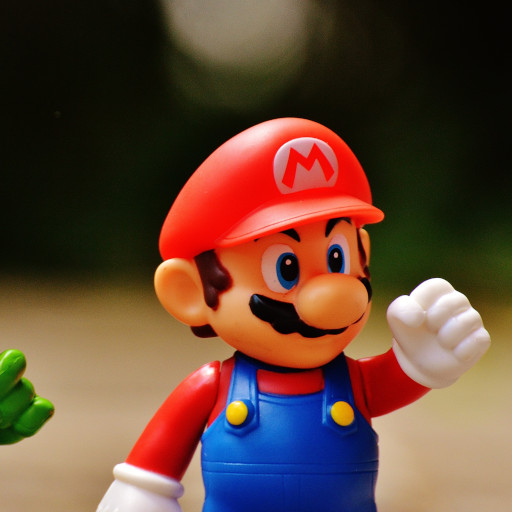

In [15]:
#Load the image
img = Image.open('./images/mario_scaled.jpg').resize((512,512));img

In [16]:
encoded = image2latent(img); encoded.shape

torch.Size([1, 4, 64, 64])

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

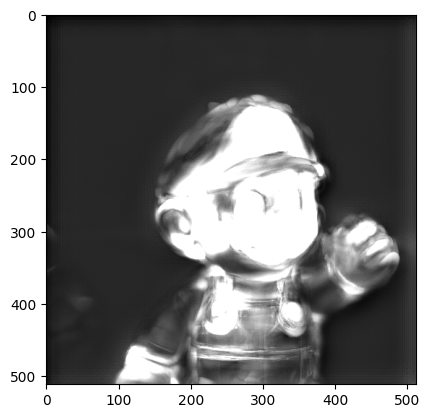

In [17]:
mario_mask = generate_mask_variant(encoded,'Mario')
plt.imshow(mario_mask.cpu().numpy(),cmap='gray')

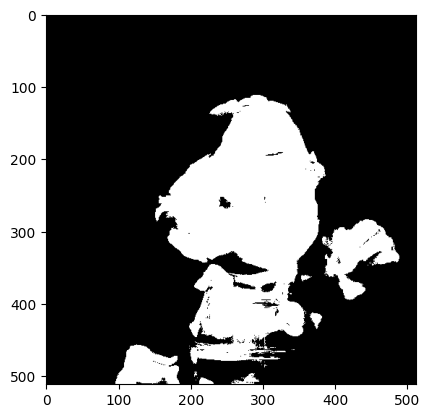

In [19]:
# 显示二值化的图像比例掩码（512,512）。
plt.imshow((mario_mask>0.5).float().cpu().numpy(),cmap='gray')

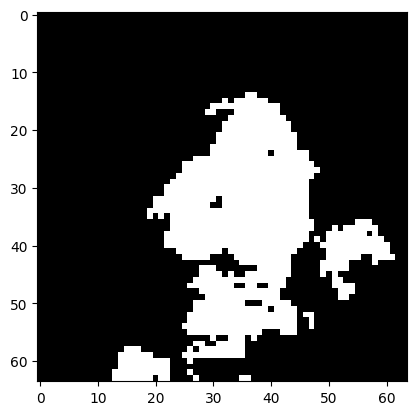

In [20]:
# 缩放并显示二值化的潜标掩码（64,64）。
scaled_mask = cv2.resize((mario_mask>=0.5).float().cpu().numpy(),(64,64),interpolation=cv2.INTER_NEAREST)
plt.imshow(scaled_mask,cmap='gray')

##  用瓦里奥取代马里奥
从提示中画出带有掩码生成的变体

seed: 16321159919113515480


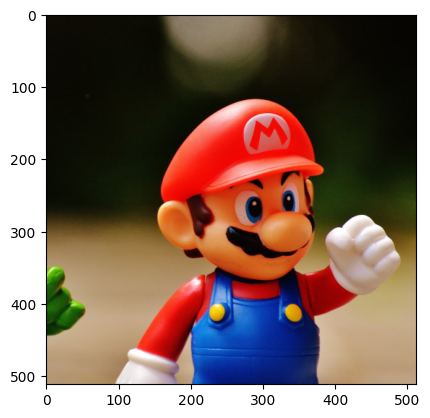

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

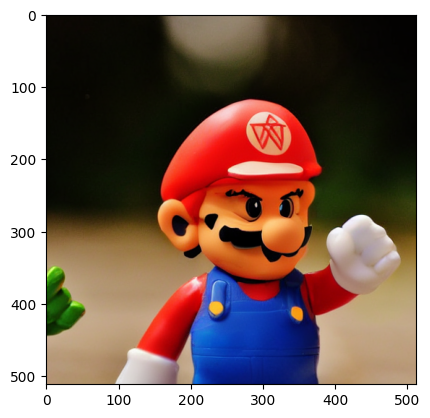

In [25]:
seed = 16321159919113515480
#seed=torch.seed()
print('seed:',seed)
mario_im = Image.open('./images/mario_scaled.jpg')
plt.imshow(mario_im)
plt.show()
mario_en = image2latent(mario_im)
plt.imshow(diffedit_variant(mario_en,'Mario','Wario',seed=seed))
plt.show()

##  用斑马代替马
从提示中画出带有掩码生成的变体

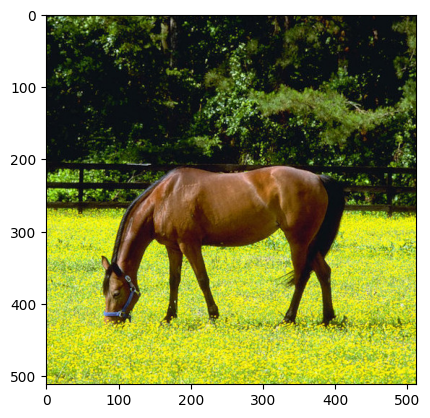

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

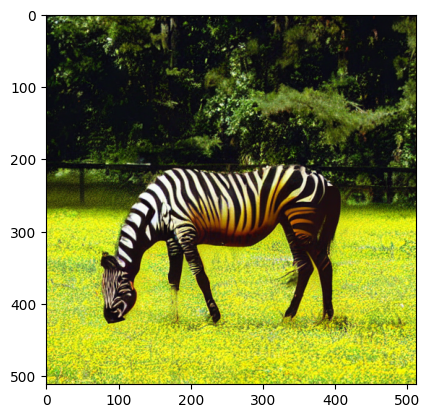

In [26]:
seed = 11794812278352456374#seed()用于指定随机数生成时所用算法开始的整数值，如果使用相同的seed()值，则每次生成的随即数都相同，如果不设置这个值，则系统根据时间来自己选择这个值，此时每次生成的随机数因时间差异而不同。且seed()可以一直生效直到下一次定义seed()时，若每次只调用一次seed()，则后续生成的随机数是固定的(根据一定的算法生成的固定随机数序列)，若每次输出前都调用seed()函数，且种子数值相同，则输出的值是固定的,seed()作用是设定生成随机数的种子，目的是为了让结果具有重复性，重现结果。
horse_im = Image.open('./images/horse_scaled.jpg').resize((512,512))
plt.imshow(horse_im)
plt.show()
horse_en = image2latent(horse_im)
plt.imshow(diffedit_variant(horse_en,'a horse image','a zebra image',seed=seed))
plt.show()

##用 "长颈鹿 "替换 "马"。
从提示中画出带有掩码生成的变体

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

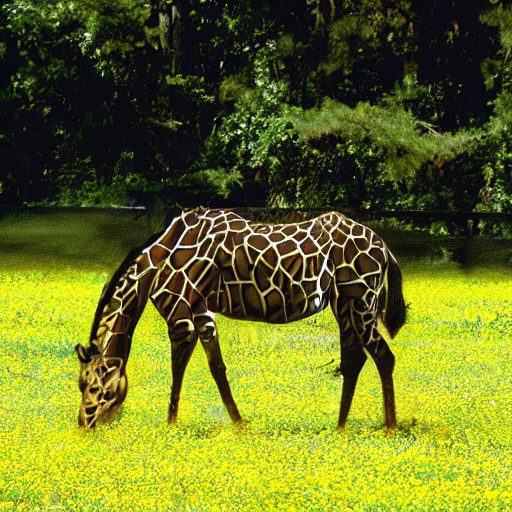

In [27]:
seed = 5327248292640123939
diffedit_variant(horse_en,'a horse image','a giraffe image',seed=seed)

##用苹果代替草莓
从提示中画出带有掩码生成的变体

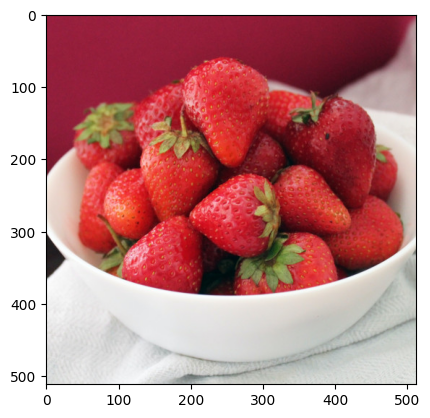

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

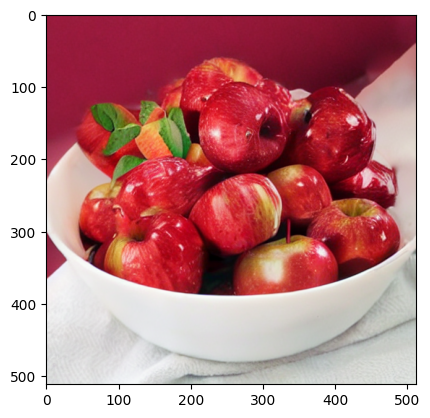

In [28]:
seed = 5327248292640123939
berry_im = Image.open('./images/bowloberries_scaled.jpg')
plt.imshow(berry_im)
plt.show()
berry_en = image2latent(berry_im)
plt.imshow(diffedit_variant(berry_en,'strawberries','apples',seed=seed))
plt.show()

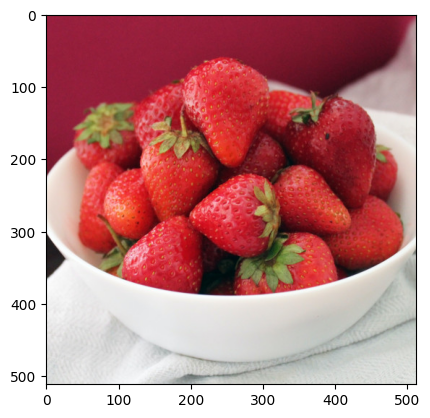

Generating Mask for Prompts:   0%|          | 0/20 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

Generating Masked Image for Prompt:   0%|          | 0/30 [00:00<?, ?it/s]

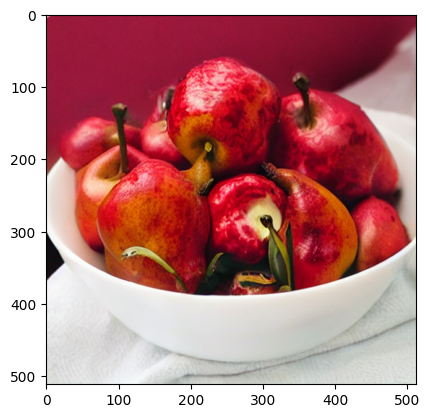

In [19]:
berry_im = Image.open('./images/bowloberries_scaled.jpg')
plt.imshow(berry_im)
plt.show()
berry_en = image2latent(berry_im)
plt.imshow(diffedit_variant(berry_en,'strawberries','pear'))
plt.show()